## practicalMixGaussA

October 2017: This lab has been converted to Python by Stratos Skordos. Any errors are my fault.  
October 2018: This lab has been checked by Mohamed Sayed. Any errors are my fault.  
October 2020: This lab has been checked by Gizem Unlu. Any errors are now my fault.

Tested against Python 3.6.6. Required Python modules:
* numpy
* scipy
* matplotlib
* pillow


This lab explores fitting simple parametric models to visual data.
The goal of this part of the lab (part A) is to fit one Gaussian model to the
data for skin and another Gaussian to non-skin pixels, and use this to
find the posterior probability that each pixel in an image is skin.
The aim of part B is to fit a mixture of
Gaussians model to one dimensional data. The aim of part C is to fit a
mixture of Gaussians model to the RGB data.
The aim of Part D is to apply what we've learned to real data.

You should use this template for your code and fill in the missing
sections marked "TO DO".




-----------------------------------
PLEASE NOTE: When implementing equations, you should only be using
"simple" numpy commands, such as np.mean(). When it comes to functions like cov(), you should
implement them yourself to show that you know what the functions are doing. 

You can check your cov() implementation against numpy's, **but
beware, sometimes there are subtle differences
between vanilla equations and what the numpy implememntation uses.**

In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio

from numpy import sqrt, pi, exp, transpose, matmul
from numpy.linalg import det, inv

%matplotlib inline

Load in a test image and the corresponding ground truth segmentation mask. Your goal for this part of the lab is to segment this 
image and acheive a segmentation mask that's close to the ground truth mask.

In [3]:
#loading the image
im = plt.imread('bob_small.jpeg')
#loading the segmentation mask  
gt = spio.loadmat('bob_GroundTruth_small.mat', squeeze_me=True)['gt']

(100, 100, 3)

Text(0.5, 1.0, 'Ground Truth')

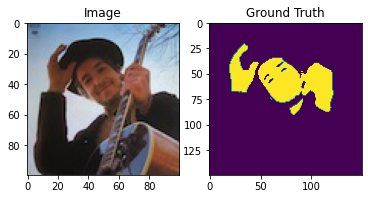

In [21]:
# display the test image and the ground truth mask

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im)
ax1.set_title('Image')
ax2.imshow(gt)
ax2.set_title('Ground Truth')
#plt.show()

The ground truth mask classifies every pixel perfectly, as expected. Yellow represents 'skin' pixel, and purple represents 'non-skin' pixel.

Load in training data. The file contains two variables. Both are sized at 3 x 10000 (3 for RGB dimensions 
and 10000(100x100) for the number of data pixels). Each column contains RGB information for one pixel. 

In [22]:
# load the file
trainingData = spio.loadmat('RGBSkinNonSkin.mat', squeeze_me=True)

#extract the non-skin matrix
RGBNonSkin = np.float32(trainingData['RGBNonSkin'])
#extract the skin matrix
RGBSkin = np.float32(trainingData['RGBSkin'])

**TODO A HERE**:

This function fits a single Gaussian distribution to your data. Fill in the TODO(s) now before moving on.

In [23]:
#==========================================================================
#==========================================================================

def fitGaussianModel(data):    
    """
    Returns the mean and covariance for a set of multidimensaional data.  
    It is assumed that each column of the 2D array, data, contains a single data point.  
    The mean vector should be a dx1 vector with the mean value of the data. For this lab, the output is a 
    3 by 1 vector containing the RGB mean of the input pixels. The covariance should be a dxd covariance
    matrix. See the note at the top, which explains that using mean() is ok,
    but please compute the covariance yourself.
    
    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions and n is the number of data points.
    
    Returns: 
    meanData -- d by 1 vector containing the mean value of the input data.
    covData -- d by d matrix containing the covariance of the input data.
    """

    nDim,nData = data.shape
    
    #TO DO (a): replace the placeholders for meanData and covData with the real equations.
    
    #calculate mean of data.  You can do this using the numpy command 'mean'
    meanData = np.expand_dims(np.mean(data, axis=1),1) 
    # We take the means of the features of the data, and different rows represent different features.
    # So we take the means of the rows.
    # The mean that we return is a column vector.
    
    #calculate covariance of data.  You should do this yourself to ensure you
    #understand how.  Check you have the right answer by comparing with the
    #numpy function np.cov().
    covData = 1/nData * (data - meanData)@(data - meanData).T
    
    return meanData, covData

Fit Gaussian models to the skin and non-skin data - make sure you've already filled in the TODO(s) in the above function.

In [24]:
#fit Gaussian model for non-skin data
meanSkin, covSkin = fitGaussianModel(RGBSkin)

#fit Gaussian model for non-skin data
meanNonSkin, covNonSkin = fitGaussianModel(RGBNonSkin)

**TODO B HERE**:

This function evaluates a Gaussian liklihood on some data. Fill in the TODO(s) now before moving on.

In [25]:
#the goal of this routine is to evaluate a Gaussian likelihood
def calcGaussianProb(data,gaussMean,gaussCov):
    """
    Returns the likelihood that each data point in data belongs to the Gaussian described by gaussMean and 
    gaussCov.
    
    Keyword arguments:
    data -- d by n matrix of data points. d is the number of dimensions and n is the number of data points.
    gaussMean -- d by 1 vector containing the mean parameter of the Gaussian distribution.
    gaussCov -- d by d matrix containing the covariance parameters of the Gaussian distribution.
    
    Returns: 
    like -- 1 by n vector contianing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by gaussMean and gaussCov.
    """
    nDim,nData = data.shape
    
    #TO DO (b) - fill in this routine, replace the placeholders for like with the actual equation.
    
    like = []
    for j in range(nData):
        likeJ = 1/((2*pi)**(nDim/2)) * det(gaussCov)**(-1/2) * exp(-0.5 * (np.expand_dims(data[:,j],1)-gaussMean).T @ inv(gaussCov) @ (np.expand_dims(data[:,j],1)-gaussMean))
        like.append(likeJ.item())

    # like is a list now. it's better if we transform it into an array. note that it will be an (n,)-dimensional array
    like = np.array(like)

    return like

**TODO C HERE**:

It's time to use our models for inference on a test image. We will first define some priors on whether or not a pixel is human skin or not. We've defined these arbitrarily here, but other more informed priors can be inforced. 

We aim to calculate a posterior probability for whether or not a pixel is skin or not. Our likelihoods are defined by the gaussian models "trained" earlier.  

For debugging's sake, we loop over every pixel and calculate its posterior individually. Feel free to vectorize this entirely after you're done with the rest of the sections.(Optional)

In [27]:
# let's define priors for whether the pixel is skin or non skin
priorSkin = 0.3
priorNonSkin = 0.7

# now run through the pixels in the image and classify them as being skin or
# non skin - we will fill in the posterior
imY, imX, imZ = im.shape
posteriorSkin = np.zeros([imY,imX])
# Remember that im is the image we loaded earlier.
# Y corresponds to the row of the pixel in question (i.e. y-coordinate) --> imY = number of pixels in the vertical = 100
# X corresponds to the column of the pixel in question (i.e. x-coordinate) --> imX = number of pixels in the horizontal = 100
# Z corresponds to the RGB values of the pixel in question (note that this is a vector containing 3 values --> dim (3,)) --> imZ = 3

for cY in range(imY): 
    print('Processing Row ',cY,'\n')
    for cX in range(imX):
        #extract this pixel's data
        thisPixelData = np.double(im[cY,cX,:]) # get double precision
        thisPixelData = thisPixelData[:, np.newaxis] # this does what I did before with np.expand_dims --> make it a column vector
        
        #make sure you've filled in calcGaussianProb above.
        
        #calculate likelihood of this data given skin model
        likeSkin = calcGaussianProb(thisPixelData,meanSkin,covSkin)
        #calculate likelihood of this data given non skin model
        likeNonSkin = calcGaussianProb(thisPixelData,meanNonSkin,covNonSkin)
        
        #TO DO (c):  calculate posterior probability from likelihoods and 
        #priors using BAYES rule.
        posteriorSkin[cY,cX] = (likeSkin[0] * priorSkin)/((likeSkin[0] * priorSkin) + (likeNonSkin[0] * priorNonSkin))

Processing Row  0 

Processing Row  1 

Processing Row  2 

Processing Row  3 

Processing Row  4 

Processing Row  5 

Processing Row  6 

Processing Row  7 

Processing Row  8 

Processing Row  9 

Processing Row  10 

Processing Row  11 

Processing Row  12 

Processing Row  13 

Processing Row  14 

Processing Row  15 

Processing Row  16 

Processing Row  17 

Processing Row  18 

Processing Row  19 

Processing Row  20 

Processing Row  21 

Processing Row  22 

Processing Row  23 

Processing Row  24 

Processing Row  25 

Processing Row  26 

Processing Row  27 

Processing Row  28 

Processing Row  29 

Processing Row  30 

Processing Row  31 

Processing Row  32 

Processing Row  33 

Processing Row  34 

Processing Row  35 

Processing Row  36 

Processing Row  37 

Processing Row  38 

Processing Row  39 

Processing Row  40 

Processing Row  41 

Processing Row  42 

Processing Row  43 

Processing Row  44 

Processing Row  45 

Processing Row  46 

Processing Row  47 

Pr

# Display the results!

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

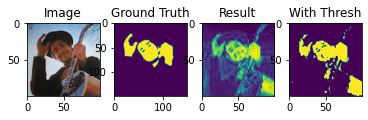

In [29]:
# set up plots.
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
#show the image
ax1.imshow(im)
ax1.set_title('Image')
#show the ground truth mask
ax2.imshow(gt)
ax2.set_title('Ground Truth')
#show our prediction!
ax3.imshow(posteriorSkin)
ax3.set_title('Result')
#show presdiction with 0.5 threshold
postWithThresh = np.round(posteriorSkin,0)
ax4.imshow(postWithThresh)
ax4.set_title('With Thresh')
plt.tight_layout
#plt.show()

Here we can compare the ground truth mask with the predicted mask. Note that we have applied a threshold of 0.5 to our predictions so that each pixel is fully classified as either 'skin' or 'non-skin' instead of an 'inbetween' probability. It can be seen that our prediction correctly classifies what is 'skin' in most cases, but it misclassifies many 'non-skin' pixels as 'skin' (false positives). This is because the pixels are considered independently, assessed soley on their RGB values, and hence, we missclassify the pixels that have a similar color to the skin of the man in the image, such as the side of the guitar or the sweater he is wearing.

Any false negatives arise mostly due to shadows.

This could be improved if we took into account correlation between nearby pixels. I don't think more data would be able to help much because if the false positives have very similar RGB values as the 'skin' pixels, they'll keep being predicted as 'skin'.